# Analyze the Data Creation

Test the effects of different constants and calculations for the data creation.

In [52]:
import numpy as np
import random
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import networkx as nx
from tqdm import tqdm

## Constants

Constants relevant for data creation are listed below. They are independet from the constants file. 
So dont forget to update the constants.py when you found some parameters you liked

In [53]:
MEAN_N_NODES = 1000
WS_NEIGHBOURS = 10
WS_PROBABILITY = 0.8
BA_NEIGHBOURS = 3

MEAN_SOURCES = 2 
MEAN_ITERS = 35
SIR_BETA = 0.01
SIR_GAMMA = 0.005
SI_BETA = 0.01

In [54]:
def select_random_sources(graph):
    """
    Selects nodes from the given graph as sources.
    The amount of nodes is randoly selected from a
    normal distribution with mean mean_sources and std mean_sources/2.
    :param graph: graph to select sources from
    :return: list of source nodes
    """
    mu = MEAN_SOURCES
    sigma = int(np.sqrt(mu))
    n_sources = np.random.normal(mu, sigma)
    # make sure there are no sources smaller than 1 or larger than 1/4 of the graph
    n_sources = np.clip(n_sources, 1, len(graph.nodes) / 4).astype(int)
    return random.choices(list(graph.nodes), k=n_sources)

In [55]:
def model_SIR_signal_propagation(graph, iterations, seed=None):
    """
    Creates a SIR model and runs it on the given graph.
    :param graph: graph to run the model on
    :param seed: seed for signal propagation
    :param iterations: number of iterations to run the model for
    :return: propagation model
    """
    model = ep.SIRModel(graph, seed=seed)
    source_nodes = select_random_sources(graph)

    config = mc.Configuration()
    config.add_model_parameter("beta", SIR_BETA)
    config.add_model_parameter("gamma", SIR_GAMMA)
    config.add_model_initial_configuration("Infected", source_nodes)

    model.set_initial_status(config)
    iterations = model.iteration_bunch(iterations)
    model.build_trends(iterations)

    return model


def model_SI_signal_propagation(graph, iterations, seed=None):
    """
    Creates a SI model and runs it on the given graph.
    :param graph: graph to run the model on
    :param seed: seed for signal propagation
    :param iterations: number of iterations to run the model for
    :return: propagation model
    """

    model = ep.SIModel(graph, seed=seed)
    source_nodes = select_random_sources(graph)

    config = mc.Configuration()
    config.add_model_parameter("beta", SI_BETA)
    config.add_model_initial_configuration("Infected", source_nodes)

    model.set_initial_status(config)
    iterations = model.iteration_bunch(iterations)
    model.build_trends(iterations)

    return model

In [56]:
def create_graph(graph_type, n_nodes):
    """
    Creates a graph of the given type.
    :param graph_type: type of graph to create
    :param n_nodes: number of nodes in the graph
    :return: created graph
    """
    n = np.random.normal(n_nodes, np.sqrt(n_nodes))
    n = np.maximum(1, n).astype(int)

    if graph_type == "watts_strogatz":
        graph = nx.watts_strogatz_graph(n, WS_NEIGHBOURS, WS_PROBABILITY)
    elif graph_type == "barabasi_albert":
        graph = nx.barabasi_albert_graph(n, BA_NEIGHBOURS)
    else:
        raise ValueError("Unknown graph type")

    return graph


def create_signal_propagation_model(graph, model_type):
    """
    Creates a signal propagation model of the given type for the given graph.
    :param graph: graph to create the model for
    :param model_type: type of model to create
    :param iterations: number of iterations to run the model for
    :return: created model
    """
    iterations = np.random.normal(MEAN_ITERS, int(np.sqrt(MEAN_ITERS)))
    iterations = np.maximum(1, iterations).astype(int)

    if model_type == "SI":
        prop_model = model_SI_signal_propagation(graph, iterations)
    elif model_type == "SIR":
        prop_model = model_SIR_signal_propagation(graph, iterations)
    else:
        raise ValueError("Unknown model type")

    return prop_model


In [57]:
def create_graphs_of_various_sizes(graph_type, model_type):
    graph_data = {}
    for MEAN_N_NODES in tqdm(range(960, 1000, 10)):
        edges_per_node = []
        infection_rate = []
        infected_nodes = []
        for i in range(10):
            graph = create_graph(graph_type, MEAN_N_NODES)
            edges_per_node.append(len(graph.edges)/len(graph.nodes))
            model = create_signal_propagation_model(graph, model_type)
            n_infected_nodes = sum([x if x == 1 else 0 for x in model.status.values()])
            infection_rate.append(n_infected_nodes/len(graph.nodes))
            infected_nodes.append(n_infected_nodes)
        graph_property = {}
        graph_property["edges_per_node"] = np.mean(edges_per_node)
        graph_property["infection_rate"] = np.mean(infection_rate)
        graph_property["infected_nodes"] = np.mean(infected_nodes)
        graph_data[MEAN_N_NODES] = graph_property
    return graph_data

In [58]:
datadict = {
    "watts_strogatz_SI": create_graphs_of_various_sizes("watts_strogatz", "SI"),
    "watts_strogatz_SIR": create_graphs_of_various_sizes("watts_strogatz", "SIR"),
    "barabasi_albert_SI": create_graphs_of_various_sizes("barabasi_albert", "SI"),
    "barabasi_albert_SIR": create_graphs_of_various_sizes("barabasi_albert", "SIR"),
}

100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


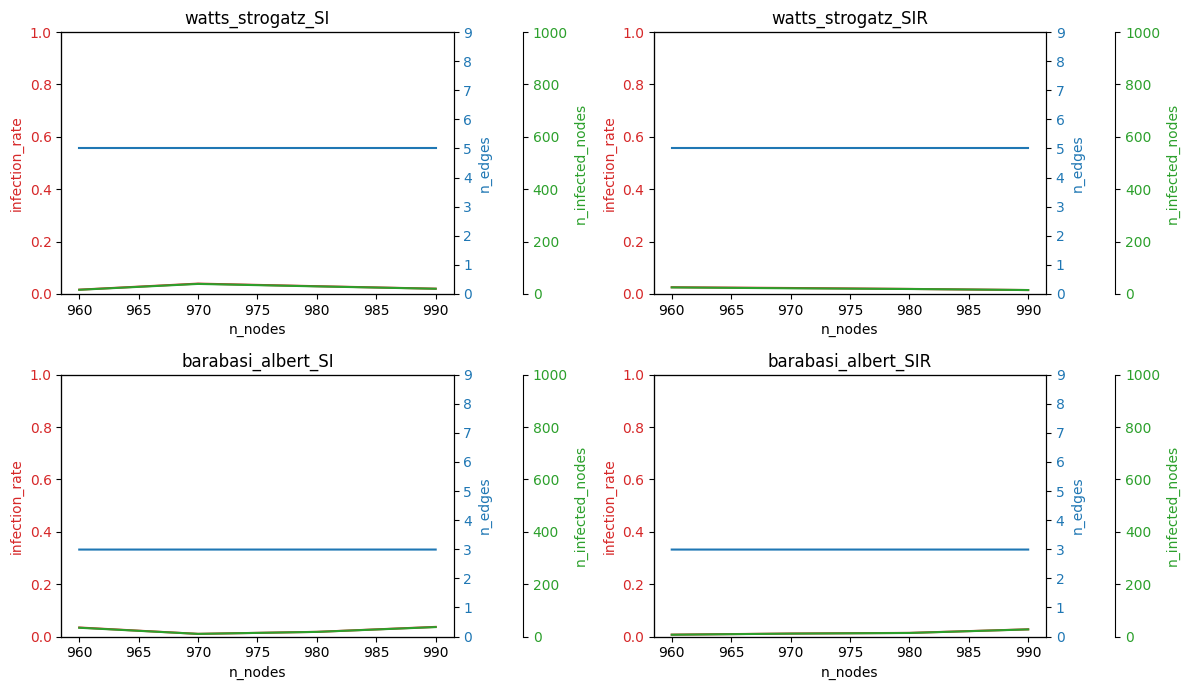

In [59]:
# now plot all data in dataset
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
for i, (title, data) in enumerate(datadict.items()):
    X = [int(x) for x in data.keys()]
    Y = [data[int(x)]["infection_rate"] for x in data.keys()]

    axs[i//2, i%2].set_title(title)

    color = 'tab:red'
    axs[i//2, i%2].set_xlabel('n_nodes')
    axs[i//2, i%2].set_ylabel('infection_rate', color=color)
    axs[i//2, i%2].set_ylim(0, 1)
    axs[i//2, i%2].plot(X, Y, color=color)
    axs[i//2, i%2].tick_params(axis='y', labelcolor=color)

    ax2 = axs[i//2, i%2].twinx()  # instantiate a second axes that shares the same x-axis
    Y = [data[int(x)]["edges_per_node"] for x in data.keys()]
    color = 'tab:blue'
    ax2.set_ylabel('n_edges', color=color)  # we already handled the x-label with ax1
    ax2.set_ylim(0,9)
    ax2.plot(X, Y, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    #instantiante a third axis to plot the number of infected nodes
    ax3 = axs[i//2, i%2].twinx()
    Y = [data[int(x)]["infected_nodes"] for x in data.keys()]
    color = 'tab:green'
    ax3.set_ylabel('n_infected_nodes', color=color)  # we already handled the x-label with ax1
    ax3.set_ylim(0,1000)
    ax3.plot(X, Y, color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.spines['right'].set_position(('outward', 50))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
